In [1]:
import os, sys, copy
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("./Code")
from InstructionDecoder import InstructionDecoder
import DataCleanup

In [2]:
def getClockOffsetFailedProfiles(_oc_):
    i = InstructionDecoder(0)
    failed = {}
    for oc in _oc_:
        i.setInstruction(oc)
        
        if i.getMemoryOffset() != 0:
            break
        
        status = i.getOcStatus()
        status *= i.getAliveStatus()
        status *= i.getTemperatureStatus()
        status *= i.getComputeStatus()
        
        key = i.getClockOffset()
        
        if status == 0:
            failed[key] = True
    
    return failed

In [3]:
def _pass_(oc):
    i = InstructionDecoder(oc)
    _alive_ = i.getAliveStatus()
    _oc_stat_ = i.getOcStatus()
    _temp_stat_ = i.getTemperatureStatus()
    _compute_stat_ = i.getComputeStatus()
    
    if _alive_*_oc_stat_*_temp_stat_*_compute_stat_ == 0:
        return False
    else:
        return True

In [4]:
dataFolder = './data750Ti_4'
files = DataCleanup.readDataDirectory(dataFolder)
profiles = [np.load(dataFolder + "/" + f) for f in files]
oc_codes = [int(f.strip('.npy')) for f in files]

### Representation of OC profiles

In [5]:
oc_data = []
with open(dataFolder+"/oc.profiles", "rb") as f:
    oc_data = f.read().decode().split(' ')[:-1]
oc_data = [int(d) for d in oc_data]
print(oc_data, len(oc_data))

[1649267441667, 1651456868355, 1651498811395, 1651540754435, 1651582697475, 1651624640515, 552154955778, 1651645612035, 552144470018, 552139227138, 552136081410, 552135032834, 552133984258, 552132935682, 1651643514883, 552131887106, 552130838530, 552129789954, 1651640369155, 1651640369155, 1651640369155, 1651640369155, 552128741378, 1651639320579, 1651639320579, 1651639320579, 1651639320579, 552127692802, 1651638272003, 1651638272003, 552126644226, 1651637223427, 1651637223427, 1651637223427, 1651637223427, 1651637223427, 1651637223427, 1651637223427, 1651637223427, 1651637223427, 1651637223427, 1651637223427, 1651637223427, 1651637223427, 1651637223427, 552125595650, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 16516361

The above shows all the overclock profiles that were applied to the system. Since we have to send the overclock profiles back and forth between the server and the client, we have decided to represent each OC profile as a 41 bit integer encoding in order to save bandwidth.

This 41 bit integer contains information about the status of the OC profile, the alive status of the system when stressing with the applied profile, the system identification number, the core clock offset, the memory clock offset, the power offset, the temperature status of the system and the computation error status.
The OC profile status is the last bit - bit 40 - in the 41 bit integer. This bit contains information as to whether or not the profile passed the stress test. A value of 1 in this bit position represents that the OC profile passed the stress test. A value of 0 indicates that it failed the test. A value of 1 in this bit position is attained if the OC profile, during the stress testing process, did not crash the system or made the system go into critical temperature regions or did not affect the accuracy of the system. A value of 0 is attained otherwise. The second to last bit - bit 39 - in the 41 bit integer is the alive status of the system. This bit indicates whether or not the system crashed during the stress test with the applied OC profile. A value of 1 in this bit position indicates that the system was stable and did not crash during the stress testing process. A value of 0 indicates that the system crashed during the testing process. Bits ranging from bits 38 to 31 represent the unique identification number of the system. This is for future expandability of the algorithm to be able to overclock multiple systems at once instead of one system at a time. The next 11 bits, ranging from bit 30 to 20 represent the core clock offset that is being applied by the OC profile. Bits 19 to 9 represent the memory offset that is being applied by the OC profile. Bits 8 to 2 represent the power offset. As of the time of writing this report, setting the power offset under Linux is not allowed for cards starting from the Pascal generation - i.e. cards starting from GTX 1060. Therefore, these 8 bits are left unused and are there for future expandability of the algorithm when post pascal cards support setting power offsets under Linux. Bit 1 is the temperature status bit. A value of 1 for this bit means that the system did not reach the critical temperature region when running stress tests with the overclocked profile. A value of 0 means that the system entered the critical temperature region at least once. Bit 0 represents the computation error status. A value of 0 for this bit indicates that there was a computation error during stress testing. A value of 1 indicates that there was no computational error. A value of 1 is only attained if the OC profile did not compromise the accuracy of the system.


# Proposed Solution

## Algorithm overview

Our OC algorithm for GPU core overclock is divided into two parts: the part that resides on the host system and the part that is on the raspberry PI. The part of the algorithm that is on the raspberry PI is the core of the algorithm. This is the part of the algorithm that generates new OC profiles based on the status of the current OC profile on the client and sends this profile to the host system over Ethernet to be evaluated. In this section we provide a generalized overview of host/client and server portions of the algorithm.

### Host/Client:

The host machine after receiving a new profile from the server applies it and runs the stress testing and monitor processes in parallel. The stress test process stresses the system by training a fully connected feed forward neural network for the classification of hand drawn digits for 20 iterations and evaluating the accuracy of the training afterwards. The monitor process constantly monitors the temperature, power draw and clock frequency at one second time intervals. The power draw and clock frequency data collected by the monitor process is solely for data analysis purposes and has no effect on the status of the OC profile under stress test. The temperature parameter collected by this process does have an effect on the status of the OC profile. If the temperature at any one second time interval is above or equal to the slowdown temperature of the GPU, then the program on the host machine that started the stress and monitor process terminates both of these processes, sets the appropriate flags to the 41 bit integer encoding of the OC profile and sends it to the server to get a new profile.

If the program on the host machine detects that it had to terminate the stress and monitor process due to temperature reasons, then the temperature bit in the OC profile encoding is set to 0. Otherwise it is set to 1. If the stress process started by the program on the host machine caused the system to crash, then the host program sets the OC status, the system alive status, and the computation error status in the OC profile encoding to 0. If the stress process did not crash the system and terminated successfully but the numerical error in the computed result is not within $2^{-52}$, then the computation error status bit of the OC profile is set to 0, otherwise it is set to 1. The numerical error, $\epsilon$, in the computed result is calculated by subtracting the expected value of the weight tensor from the reference model from the weight tensor obtained in the current training process run by the stress program in a separate process and calculating the 2-norm of the resultant tensor. This is represented formally in the following equation where $W_{ref}$ and $W_{c}$ are the reference and current weight tensors respectively with dimensions $m$, $n$ and $p$:

$$
\epsilon = \sum_{i=0}^{m}\sum_{j=0}^{n}\sum_{k=0}^{p} (W_{ref}[i,j,k] - W_{c}[i,j,k])^{2}
$$

If, however, the termination of the stress and monitor process by the host program was caused due to the temperature of the system, reported by the temperature process, reaching critical levels, the overclock status bit and temperature status bit of the OC profile encoding is set to 0. Otherwise, the temperature status bit is set to 1 and the overclock status bit is left unmodified. Note that stress and monitor process terminations due to temperature reasons do not modify the computation error bit or error bit.

After the program running on the host machine sets the appropriate bits of the encoding it is sent to the raspberry PI server along with a string appended to the end of the encoding that either reads $MEMORY$ or $CORE$ separated by a comma character. This string tells the algorithm on the PI whether to generate a new profile by changing the memory offset or the core offset. Decision to append the $MEMORY$ or $CORE$ string is determined by the program running on the host machine. The program running on the host machine starts off by first applying the core offset in the OC profile encoding while setting the memory offset to zero. During this time every request containing the encoding sent to the server has the $CORE$ string appended to it. Once the host program is able to run an OC profile - that changes only the core offset - successfully for 20 iterations in a row, it determines the core offset specified in that profile to be the final stable offset that when applied to the core clock does not compromise accuracy or system stability. Once a stable core offset has been found, the host program then moves on to overclocking the memory by setting memory and core offsets to that specified in the profile. During this time every request sent to the server containing the encoding has the $MEMORY$ string appended to it. Once the host program is able to run an OC profile that has both the memory and core offsets for 20 iterations in a row it is done overclocking the system. Generally the core offset in the profile is left unchanged by the sever if a stable core offset with zero memory offset was found.

### Server:

The algorithm on the server maintains seven variables which it uses to generate new OC profiles. These variables are: last known good profile, a list of failed core clock offsets, a list of failed memory clock offsets, max core clock offset, max memory clock offset, core clock offset increment, and memory clock offset increment. This algorithm can be broken up into two components: the max offset finder, and the stabilizer.

The purpose of the max offset finder is to find and set values for the max clock offset and max memory offset variables. The max clock offset value is found by first setting the core clock offset increment to a value of 40MHz and generating a last known good profile whose core and memory offsets are set to zero. A new profile is then generated from this last known good profile by applying an increment of core clock offset increment value to the core clock offset in the last known good profile. This new generated profile is then sent to the client/host to be evaluated. If the evaluation passes, then this new profile is set as the last known good profile and another increment of core clock offset increment is applied to the core clock offset of this last known good profile and sent to the client to be evaluated. This process continues till the server receives a profile that failed. When this happens, the value of the core clock offset in the failed profile is set as the value of max core clock offset variable. This same procedure is repeated when finding the max memory clock offset value. When this portion of the algorithm finds a max value for the memory or clock offset, it adds them to the list of failed memory and clock offsets respectively. This is because the max offset finder does not assign an offset as max if it did not fail the host evaluation. This portion of the algorithm has to run before the stabilizer portion.

The stabilizer portion of the algorithm is responsible for finding a stable clock offset for both the core clock and the memory clock given the max clock offsets for both. This is done by incrementing the core clock or memory clock offset in the last known good profile by the core clock or memory clock offset increment values while also making sure that after the application of the increment values, the offsets in the profile do not exceed their respective max values. If either the core offset or the memory offset in the last known good profile exceeds their respective maximum values, then the respective increments are halved and reapplied. This process of halving the increment continues till an increment is found that after application does not exceed the offset maximum values: max core clock offset for application to core offset, or max memory clock offset for application to memory offset. If, after halving, the increment is zero, then the increment is set to -1. This applies to both the memory and core increments. After the application of the offset increments, the newly generated OC profile is sent to the client to be evaluated. If the evaluation passed, the last known good profile is set to the current OC profile that passed and the above procedure repeated to generate a new OC profile. If the evaluation fails, the max offsets are set to the offsets in the failed OC profile and the above procedure repeated to generate a new profile. This portion of the algorithm either stabilizes the core or the memory clock offset depending on the string that was appended to the end of the OC profile encoding in the request received from the client. If the string read $CORE$, then the core offset would be stabilized, else if the string read $MEMORY$, then the memory offset would be stabilized following the above procedure.

When the server first receives the base OC profile from the client, it runs the max offset finder till it finds a max offset for either the core or the memory offset depending on the appended string at the end of the client request following the encoding separated by a comma. If this string reads $MEMORY$, then the memory max offset finder is run, else if it reads $CORE$, the core max offset finder is run. After the algorithm finds a max ocffset for the memory or the core, it runs the stabilization portion to find a stable offset for core and memory. The stabilizer also modifies the max offsets so that the algorithm converges to the right stable OC profile offsets.

## Proposed solution implementation

Due to certain complexities associated with socket programming, we have implemented the proposed algorithm in Python. The implementation contains 8 modules. These are: the instruction decoder module, the monitor module, the neural networks module written using PyTorch, the stress module, the GPU module, the OC algorithm module and the server and the client module.

The instruction decoder module is responsible for decoding the 41 bit integer OC profile encoding and returning or setting flags and values such as the temperature status flag and/or the core offset value. This module consists of 8 getters and 8 setters. The set of getters return the OC status, the alive status, the system identification number, the clock offset, memory offset, power offset, temperature status, and compute status from the 42 bit integer encoding. The set of setters set the exact same attributes for the 42 bit encoding. There is however one additional getter that returns the complete modified 41 bit integer. The purpose of this module is to make manipulating the attributes in the encoding easier by providing high level abstraction functions to low level bit operations.

The monitor module is one of the two processes forked by the program on the host/client system when running stress tests on the OC profile. The purpose of this module is to monitor and report certain attributes in the system. These attributes include: the temperature of the system, power draw, current core clock speed, and current memory clock speed. The host program currently uses the temperature value returned by this module to assess whether or not to terminate the stress. If the temperature is in the critical region, the host program terminates the stress and marks the OC profile as failed by setting the appropriate bits using the instruction decoder module.

The neural network module is part of the stress module, in that this module is used in the stress module to stress the system by running a training task and assessing the stability and accuracy of the system. The job of this module is to take in as input a training dataset, the number of iterations to train the network, and a network structure configuration. The network structure configuration is a list of integers where the length of this list represents the number of internal layers in the fully connected feed forward network and the number of perceptrons in each of those layers. The neural network module can only create fully connected feed forward network structures. The activation function used is the hyperbolic tangent function, and the loss function is the cross entropy loss. This module is entirely implemented using PyTorch [citation needed]. This module also contains a function to return the weight tensor of the network either before the training or after the training. The weight tensor returned by this function is used for accuracy assessment after application of each OC profile. The weight tensor of the trained NN in the non-overclocked system is stored as a reference, an OC profile is applied and the new weight tensor is extracted from the trained model. If the 2-norm of the difference between the reference weight tensor and the new weight tensor is greater than the precision of floating point numbers, then the accuracy of the system is compromised.

The purpose of the stress module is to use the neural network module to create and train a neural network model for the classification of hand drawn digits obtained from the MNIST hand drawn digits dataset [xx]. The stress process creates a neural network with [[625, 463, 607, 540, 994, 659, 832, 544, 808, 551, 655, 840]] as the hidden layer configuration. The number of inputs to this model is 784 since the images are 28 by 28 pixels. The number of outputs is 10, since there are 10 classes of digits from 0 to 9. After the neural network has been set up, it is trained for 20 iterations and the accuracy and stability of the system is assessed using the 2-norm of the tensor difference. 

The GPU module is a wrapper for NVIDIA settings and smi programs. The nvidia-settings program is used to set certain attributes to the GPU such as setting the core clock offset, and the memory offset. The nvidia-smi program is used to collect information about the GPU such as temperature, power draw, core clock and memory speeds. This module wraps the settings program from NVIDIA and uses it to set the core and memory offset by providing high level function abstractions to low level call of the settings program. This module also does the same to the smi program, in that it wraps the smi program and provides high level function abstractions to low level smi program calls for getting critical information such as temperature, power draw, and clock speeds from the GPU. This module is mostly used by the monitor process to collect and report information about the GPU to the host program.

The OC algorithm module contains the algorithm that is applied by the server to the OC profile received from the client to generate a new OC profile. This module is entirely and only used by the server module. This module contains 7 variables that it uses to keep track of its progress and the changes it made to the received OC profile to generate a new profile. These 8 variables are: the last known good profile, the core clock offset increment value, the memory clock offset increment value, the max core clock offset limit, the max memory clock offset limit, and two lists containing the failed core offsets and the failed memory offsets. This module contains only two functions: the adjustment function and the generate new profile function. The generate new profile function is always called immediately after the adjustment function. The purpose of the generate new profile function is to only set the core and memory offsets in the new generated profile depending on the $CORE$ or $MEMORY$ string.

The adjustment function can be divided into two components: the max offset finder and the stabilizer. The max offset finder is used to find the initial maximum offset for either the core or the memory offset depending on the appended string at the end of the request from the client. Once the max offset finds the initial maximum offset that can be applied to the memory or core, the stabilizer generates new OC profiles for either the memory or core offset or both making sure not to generate an OC profile that exceeds the offset maximums for core or memory. This new generated profile is sent to the host to be evaluated. If the evaluation passes, the adjustment function in run and a new profile is generated. This process continues for either the core or memory overclock - depending the $CORE$ or $MEMORY$ string - until this algorithm generates an OC profile that is able to run for 20 times in a row without causing the host system to become unstable or compromising its accuracy.
The server module is the part of the entire process that resides on the raspberry PI and applies the overclock algorithm in the OC algorithm module to OC profiles it receives from the client to generate a new OC profile and send the new profile to the client. The server continuously waits for a request from the client. Once the client – in the client module – establishes a connection, it sends the OC profile it evaluated to the server. The server passes this received OC profile through the algorithm module to generate a new OC profile and send it to the client.

The client module is the last module in the entire system. In this paper, the client and the host are used interchangeably, since in the context of this paper we are referring to the host as a machine that has a GPU that is connected to the PI. The client module is responsible for sending and receiving OC profiles back and forth from the server. When the client receives an OC profile from the server it immediately starts evaluating it and sends the result of the evaluation to the server to get a new profile. This process is repeated till an OC profile is found that runs successfully for 20 iterations in a row.


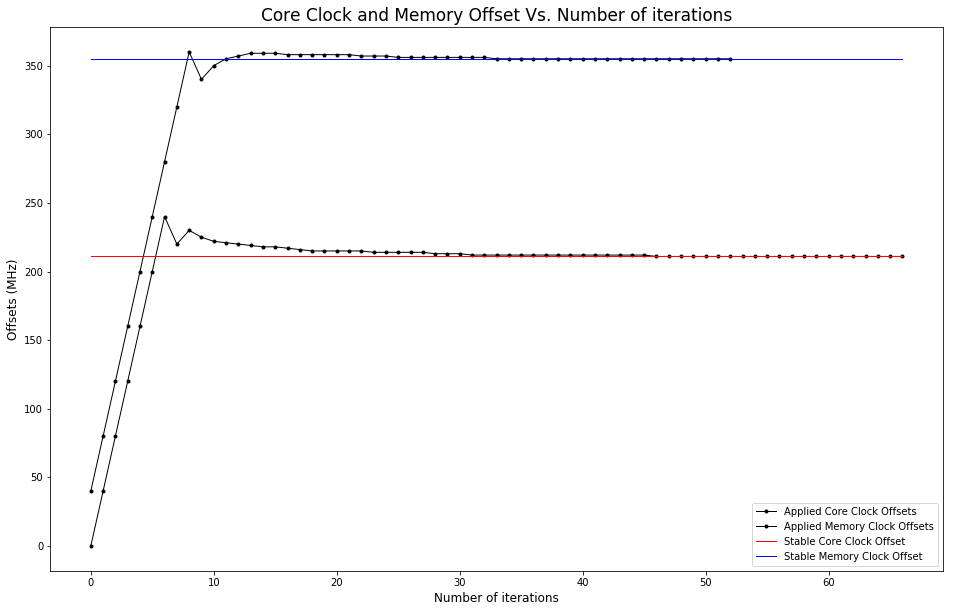

In [16]:
actual = InstructionDecoder(oc_data[-1]).getClockOffset()
values = [
    InstructionDecoder(oc).getClockOffset() 
    for oc in oc_data 
    if InstructionDecoder(oc).getMemoryOffset() == 0
]
core_actual = copy.deepcopy(actual)
core_values = copy.deepcopy(values)

plt.figure(figsize=(16, 10))
plt.title("Core Clock and Memory Offset Vs. Number of iterations", fontsize=17)
plt.ylabel("Offsets (MHz)", fontsize=12)
plt.xlabel("Number of iterations", fontsize=12)

plt.plot(values, '-ok', label='Applied Core Clock Offsets', linewidth=1, markersize=3)

actual = InstructionDecoder(oc_data[-1]).getMemoryOffset()
values = [
    InstructionDecoder(oc).getMemoryOffset() 
    for oc in oc_data 
    if InstructionDecoder(oc).getMemoryOffset() != 0
]


plt.plot(values, '-ok', label='Applied Memory Clock Offsets',  linewidth=1, markersize=3)

length = np.max([len(core_values), len(values)])
plt.plot([core_actual]*length, '-r', label='Stable Core Clock Offset', linewidth=1)
plt.plot([actual]*length, '-b', label='Stable Memory Clock Offset', linewidth=1)

plt.legend(loc='lower right', fontsize=10)


plt.savefig("Algorithm OC profile application.jpg")
plt.show()

In [19]:
failed = getClockOffsetFailedProfiles(oc_data)

PowerConsumption0.jpg


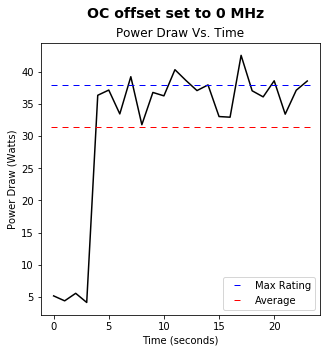

PowerConsumption40.jpg


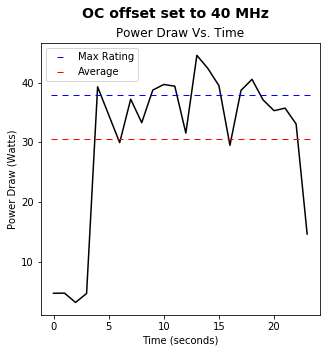

PowerConsumption80.jpg


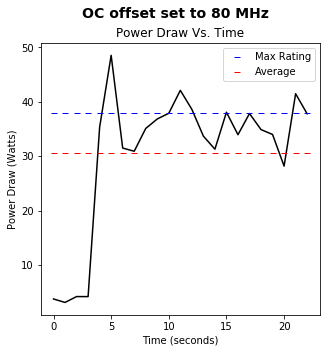

PowerConsumption120.jpg


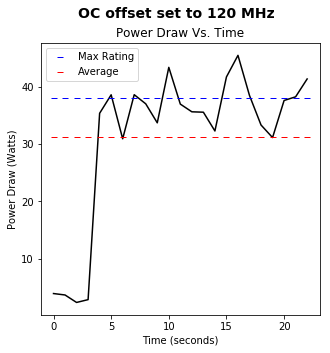

PowerConsumption160.jpg


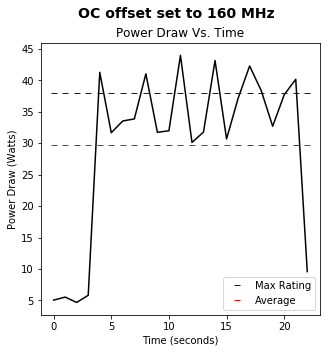

PowerConsumption200.jpg


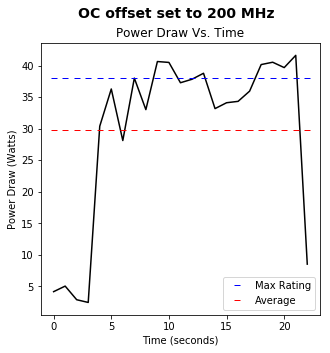

PowerConsumption211.jpg


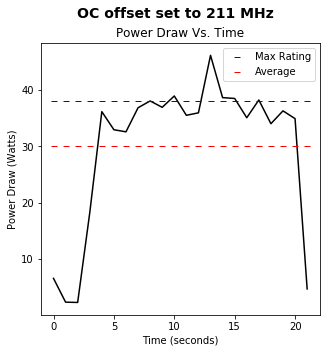

In [27]:
previous_core_offset = -1
nrows = 1
ncols = 3
sample_rate = 1/1
for i in range(len(profiles)):
    instruction = InstructionDecoder(oc_codes[i])
    clock_offset = 1346 + instruction.getClockOffset()
    
    title_ = ''
    
    # filter failed OC profiles
    if  instruction.getOcStatus()==0 or \
        instruction.getAliveStatus()==0 or \
        instruction.getTemperatureStatus()==0 or \
        instruction.getComputeStatus==0:
        title_ = "OC offset set to %s MHz"%(str(instruction.getClockOffset()))
    else:
        title_ = "OC offset set to %s MHz"%(str(instruction.getClockOffset()))
#     title_ += ", Failed" if instruction.getClockOffset() in failed else ", Passed"
        
    if instruction.getClockOffset() in failed:
        continue
        
    # This also takes care of removing the entries with memory offset
    if instruction.getClockOffset() == previous_core_offset:
        continue
    else:
        previous_core_offset = instruction.getClockOffset()
    
    temperature = profiles[i][:,0]
    power_draw = profiles[i][:,1]
    gpu_core_clock = profiles[i][:,2]
    sm_clock = profiles[i][:,3]
    memory_clock = profiles[i][:,4]
    time_axis = [sample_rate*i for i in range(len(gpu_core_clock))]
    

    plt.figure(figsize=(5, 5)).suptitle(title_, fontsize=14, fontweight='bold', va='top')
    
#     plt.subplot(nrows, ncols, 1)
#     plt.title("Temperature Vs. Time")
#     plt.xlabel('Time (seconds)')
#     plt.ylabel('Temperature ($^\circ$C)')
#     plt.plot(time_axis, temperature, '-k')
#     plt.plot([np.mean(temperature)]*int(np.ceil(time_axis[-1])+1), '_r', label='Average')
#     plt.legend()
    
#     plt.subplot(1, 1, 2)
    plt.title("Power Draw Vs. Time")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Power Draw (Watts)')
    plt.plot(time_axis, power_draw, '-k')
    plt.plot(time_axis, [38]*len(power_draw), '_b', label='Max Rating')
    plt.plot([np.mean(power_draw)]*int(np.ceil(time_axis[-1])+1), '_r', label='Average')
    plt.legend()
    
#     plt.subplot(nrows, ncols, 3)
#     plt.title("GPU Core Clock Vs. Time")
#     plt.xlabel('Time (seconds)')
#     plt.ylabel('Gpu Clock (MHz)')
#     plt.plot(time_axis, gpu_core_clock, 'k')
#     plt.plot([np.max(gpu_core_clock)]*int(np.ceil(time_axis[-1])+1), '_b', label='Max')
#     plt.plot([np.mean(gpu_core_clock[4:])]*int(np.ceil(time_axis[-1])+1), '_r', label='Average')
#     plt.plot([np.min(gpu_core_clock)]*int(np.ceil(time_axis[-1])+1), '_g', label='Min')
#     plt.legend(loc='lower right')
    
    _file_name_ = "PowerConsumption"+str(instruction.getClockOffset())+".jpg"
    print(_file_name_)
    plt.savefig(_file_name_)
    plt.show()

[0, 40, 80, 120, 160, 200, 209]
[45, 44, 43, 42, 42, 41, 39]


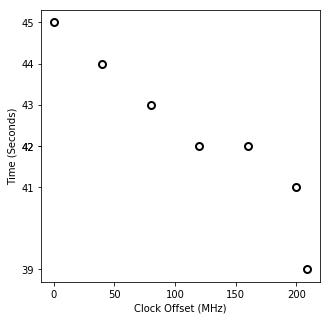

[40, 60, 80, 100, 110, 125, 140, 144, 143, 142, 141, 139, 138, 137, 136, 135, 134, 133, 132, 130, 129, 128, 127, 126, 124, 123, 122, 120]
[39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 41, 41, 42, 41, 42, 41, 41, 39, 39, 39, 39, 39, 39, 39, 39, 39]


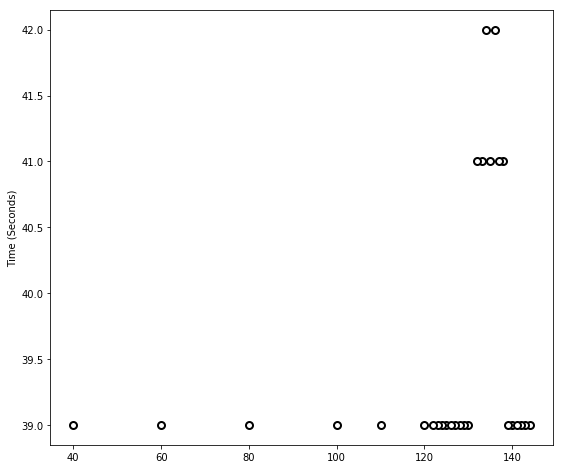

In [29]:
# get time taken for stress process during overclocking as 
# core clock offset is increased
core_clock_offset, _time_ = [], []
for i in range(len(profiles)):
    instruction = InstructionDecoder(oc_codes[i])
    
    if not _pass_(oc_codes[i]): 
        continue
        
    if instruction.getMemoryOffset() != 0:
        continue
    
    if instruction.getClockOffset() in failed:
        continue
    
    core_clock_offset += [instruction.getClockOffset()]
    _time_ += [len(profiles[i])]
    
print(core_clock_offset)
print(_time_)
plt.figure(figsize=(5,5))
plt.ylabel("Time (Seconds)")
plt.xlabel("Clock Offset (MHz)")
# plt.xticks(core_clock_offset)
plt.yticks(_time_)
plt.plot(core_clock_offset, _time_, 'ok', markersize=7, markeredgewidth=2, markerfacecolor='white')
plt.show()


# get time taken for stress process during overclocking as 
# memory clock offset is increased
memory_clock_offset, _time_ = [], []
for i in range(len(profiles)):
    instruction = InstructionDecoder(oc_codes[i])
    
    if not _pass_(oc_codes[i]): 
        continue
        
    if instruction.getMemoryOffset() == 0:
        continue
        
    memory_clock_offset += [instruction.getMemoryOffset()]
    _time_ += [len(profiles[i])]

print(memory_clock_offset)
print(_time_)
plt.figure(figsize=(9,8))
plt.ylabel("Time (Seconds)")
plt.plot(memory_clock_offset, _time_, 'ok', markersize=7, markeredgewidth=2, markerfacecolor='white')
plt.show()

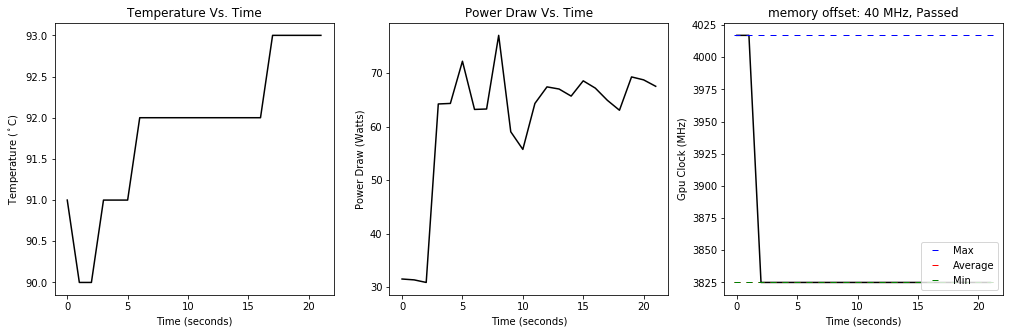

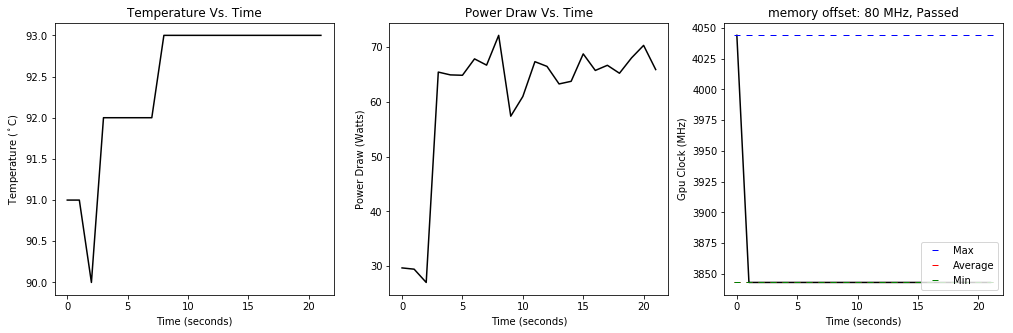

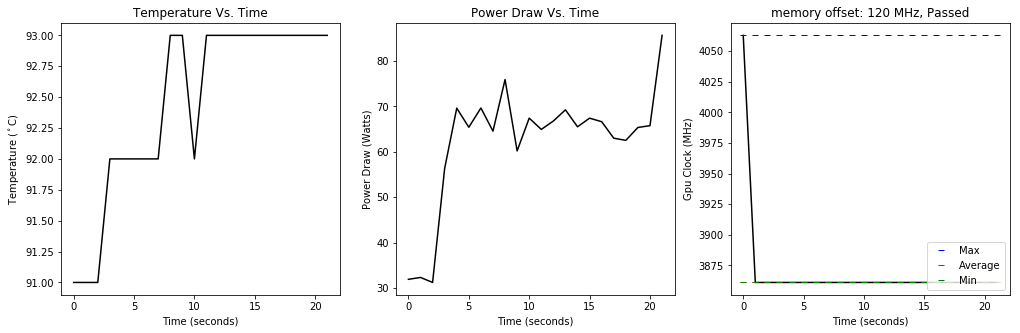

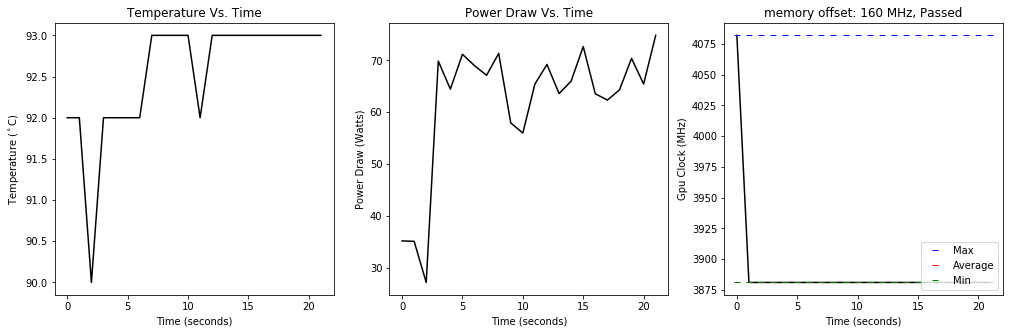

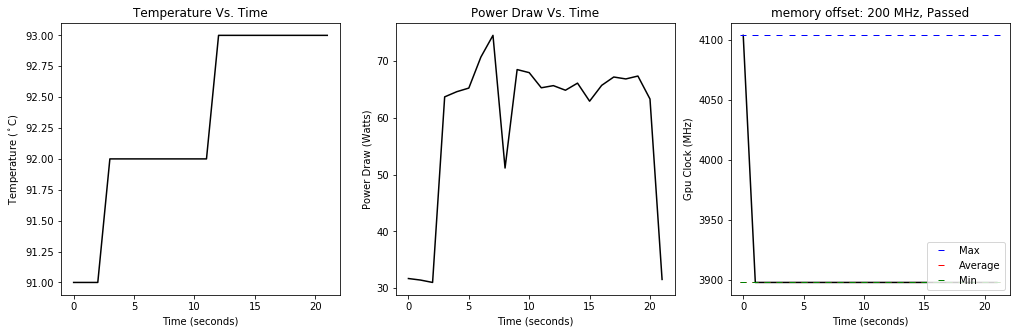

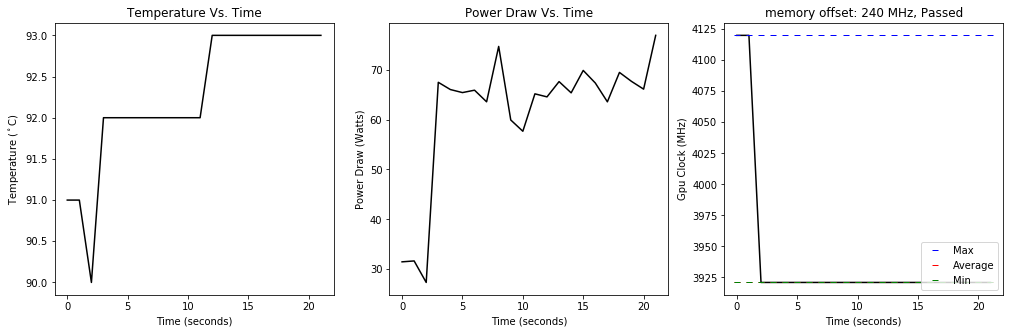

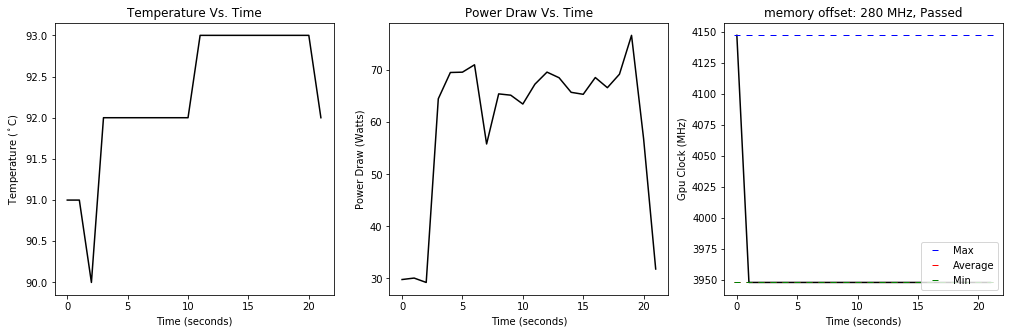

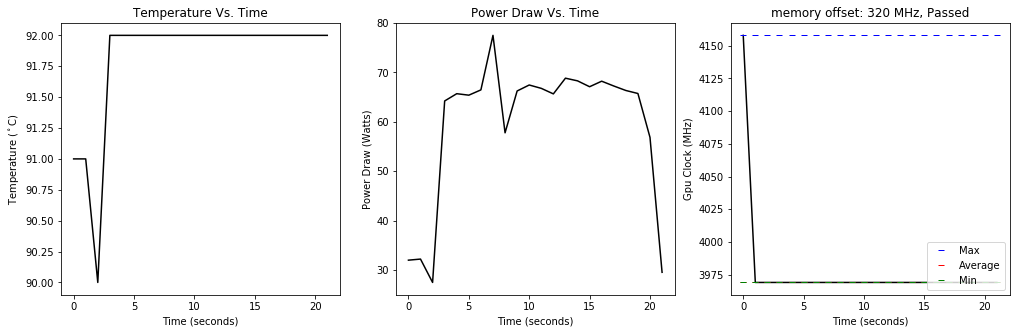

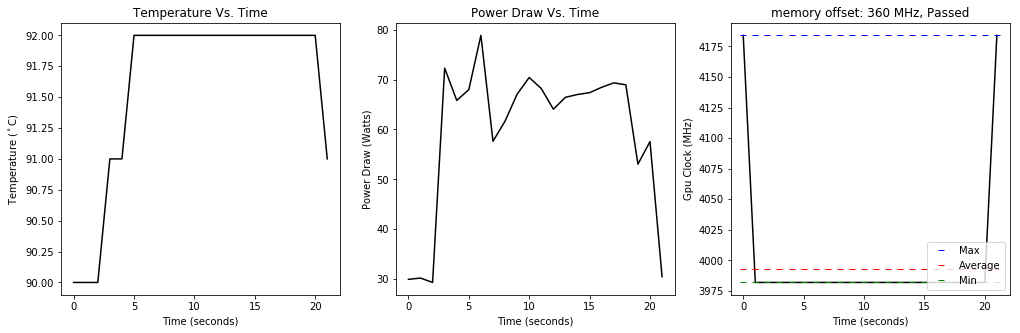

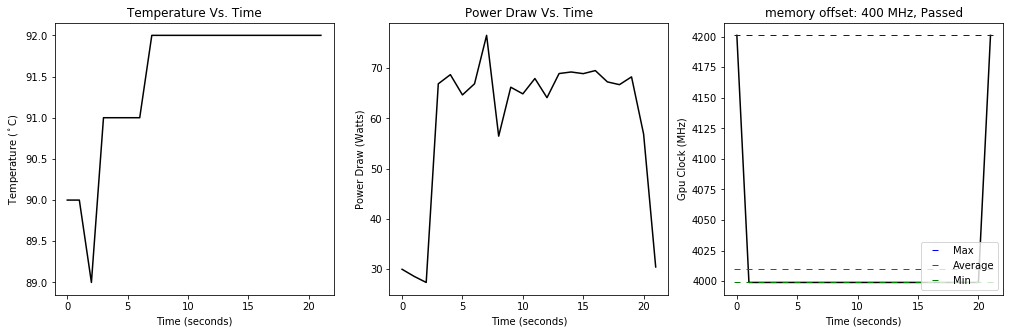

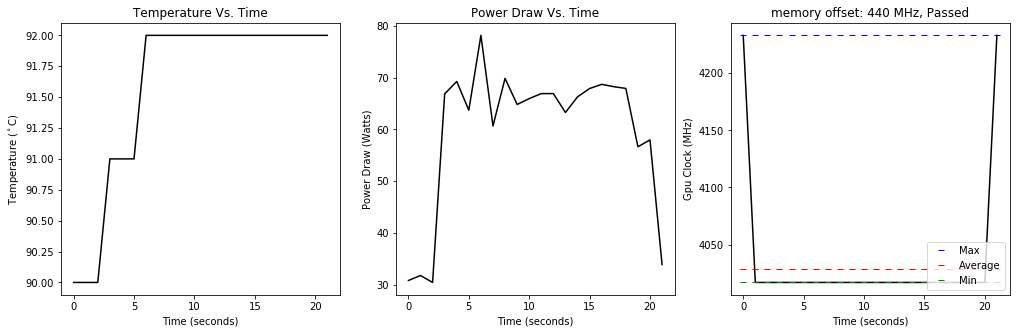

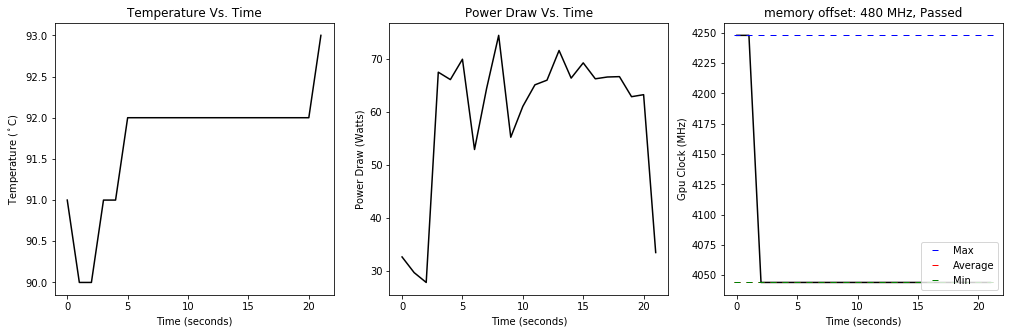

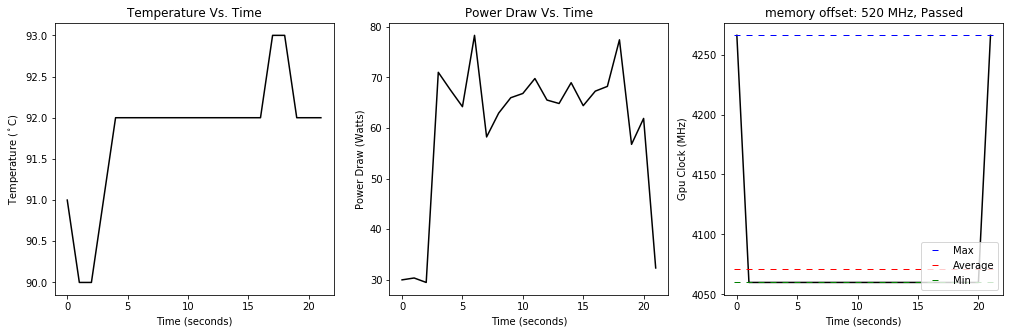

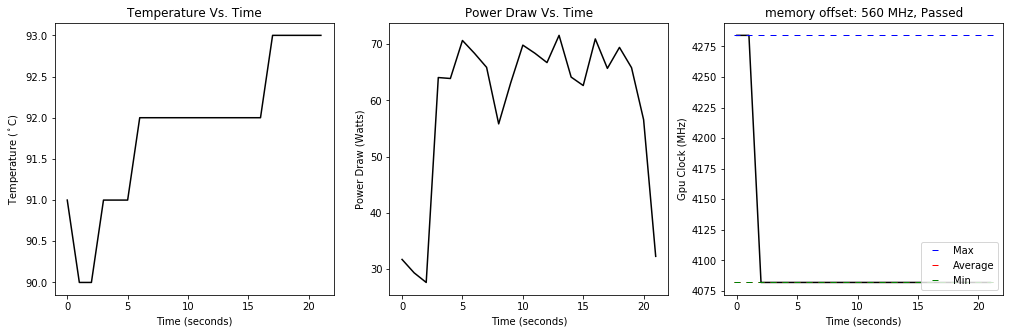

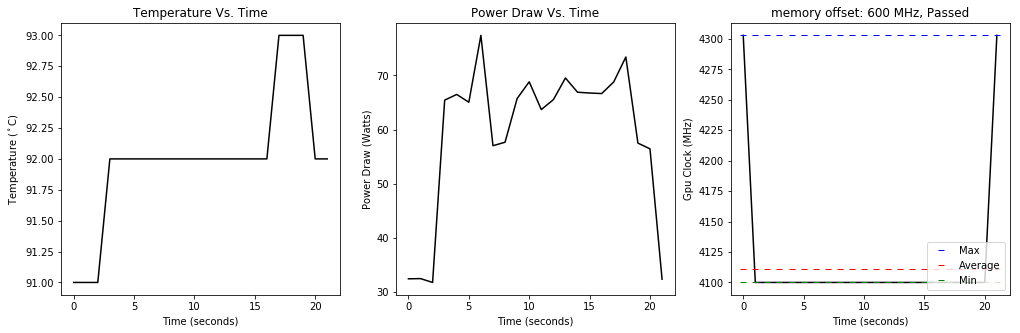

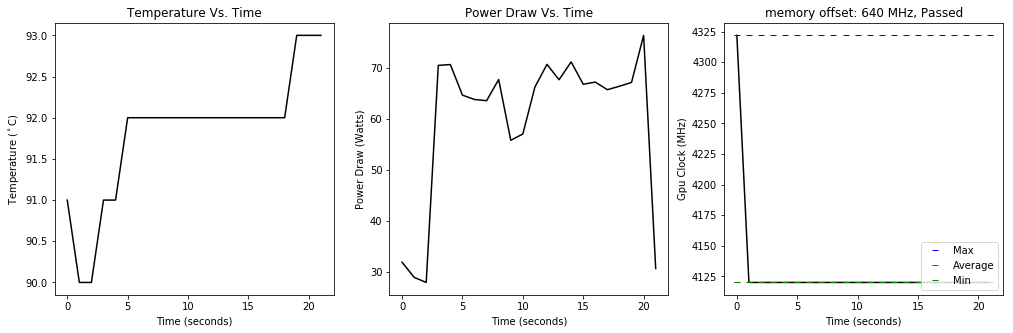

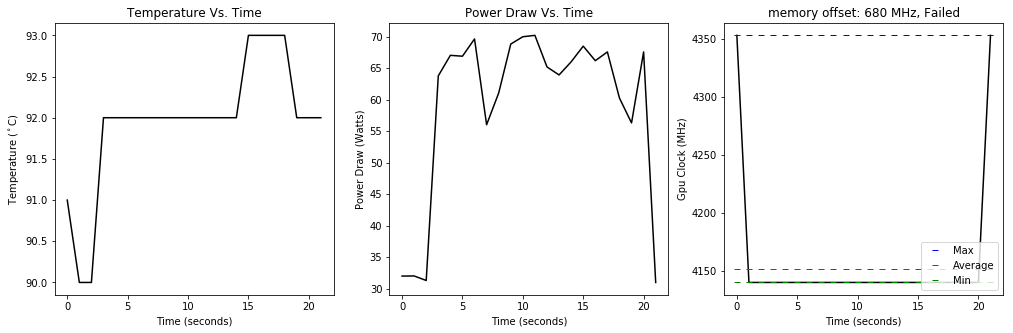

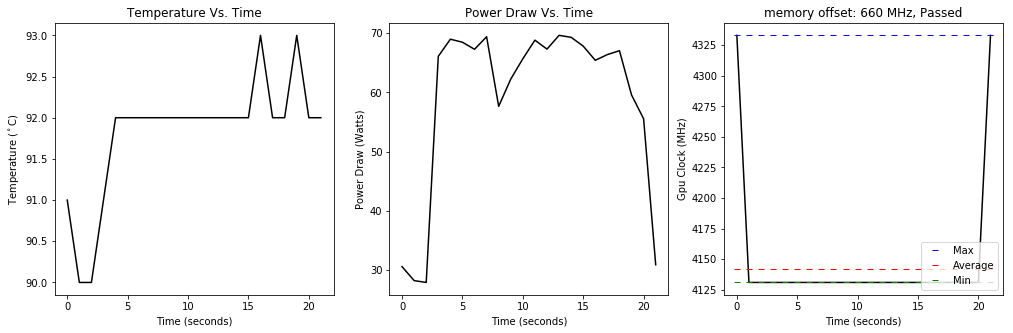

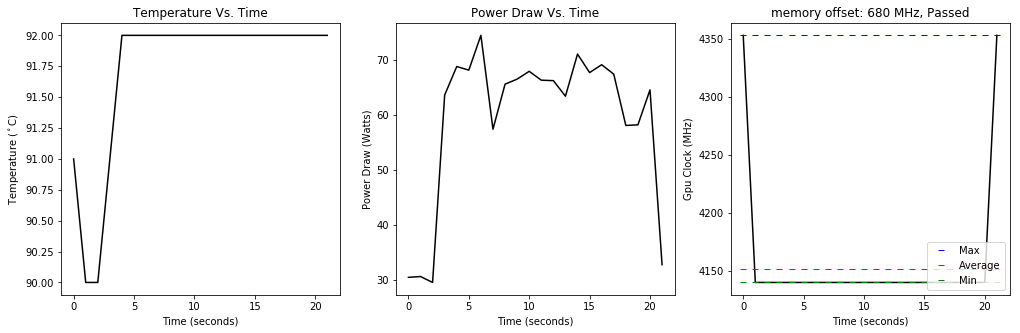

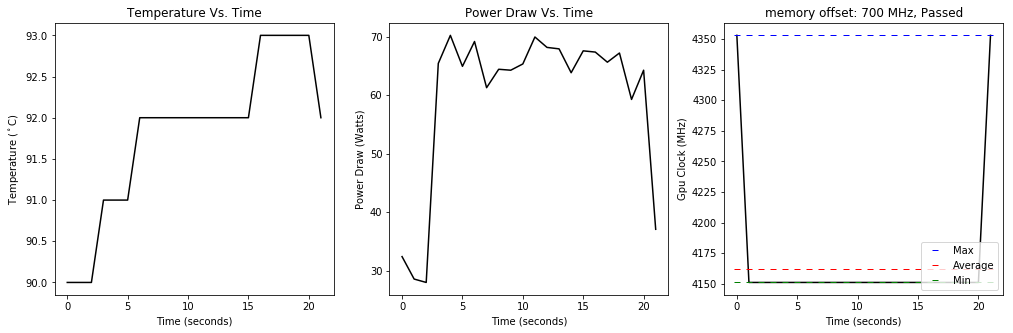

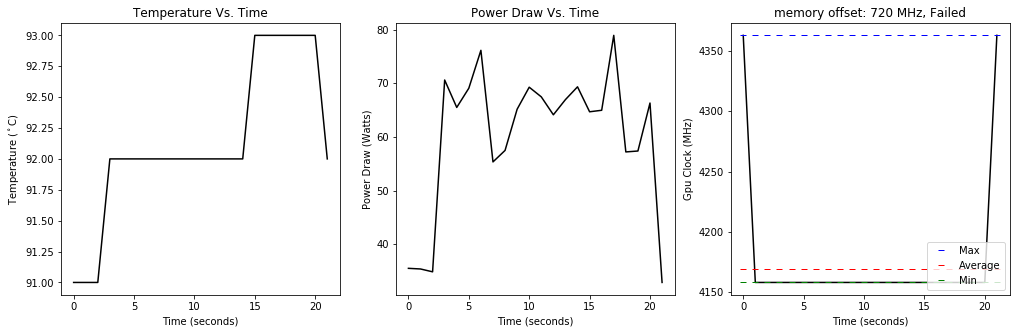

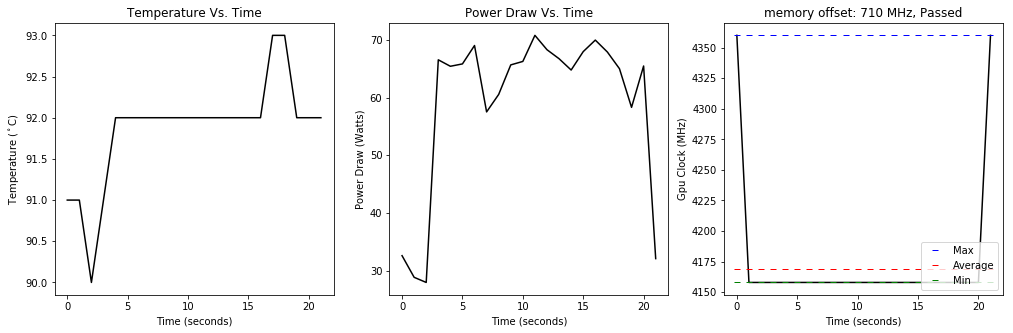

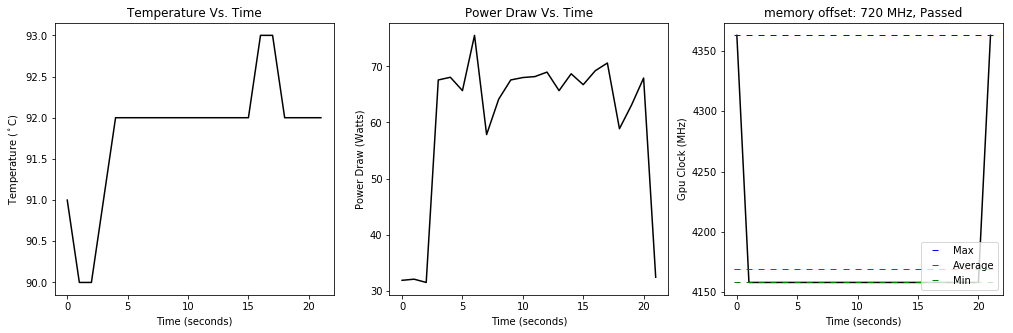

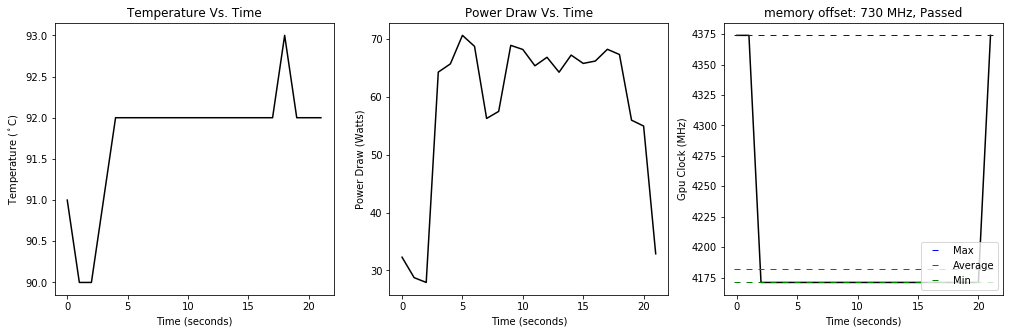

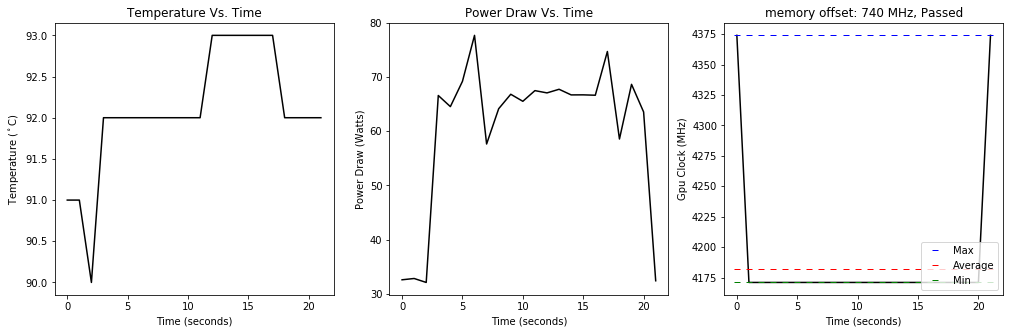

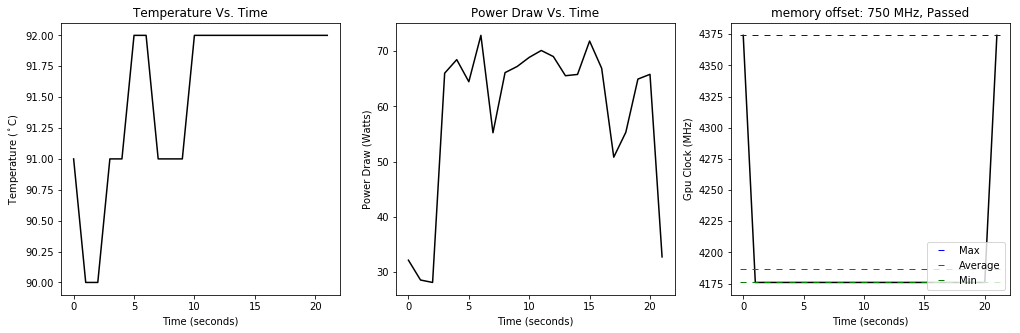

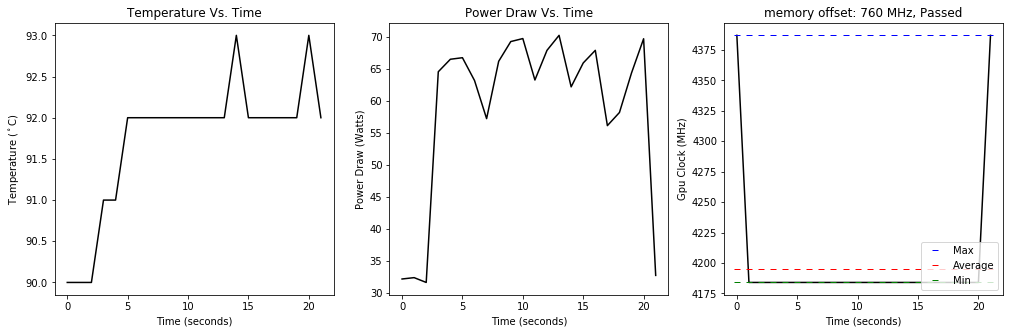

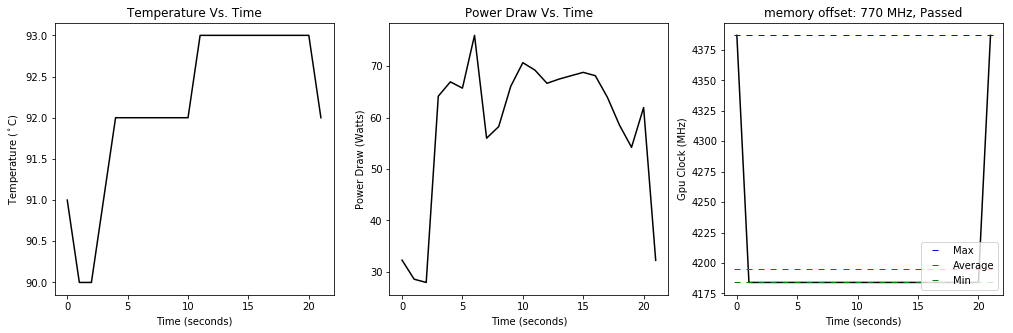

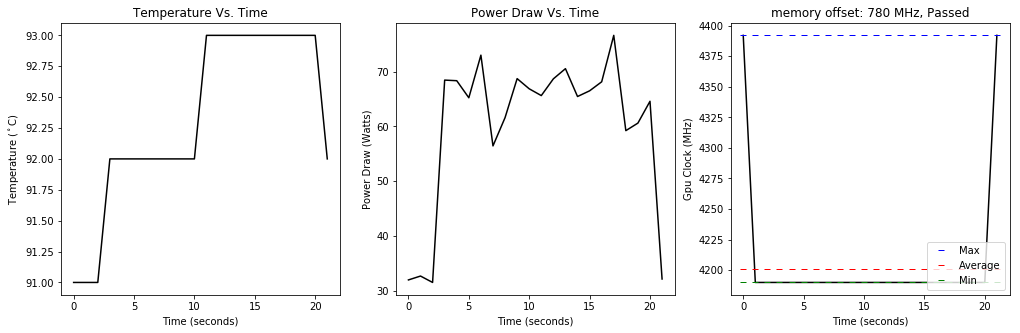

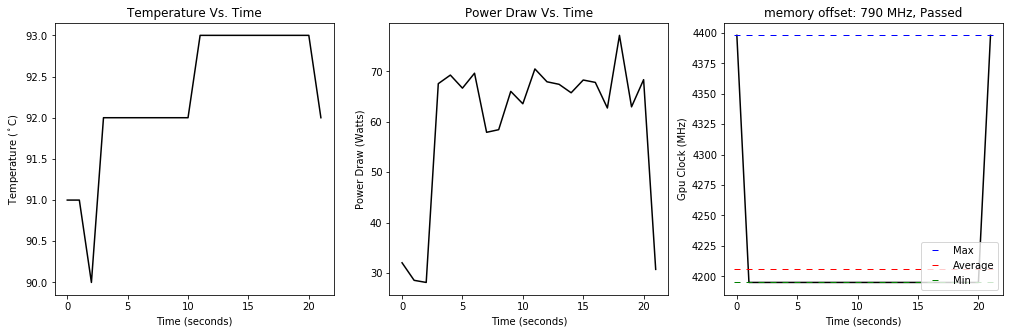

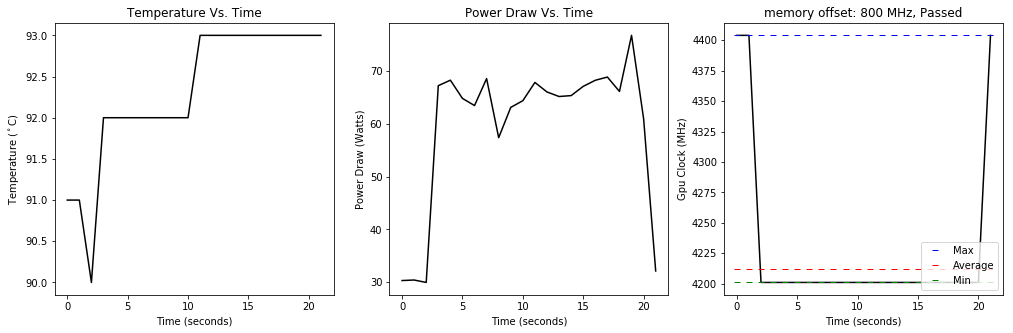

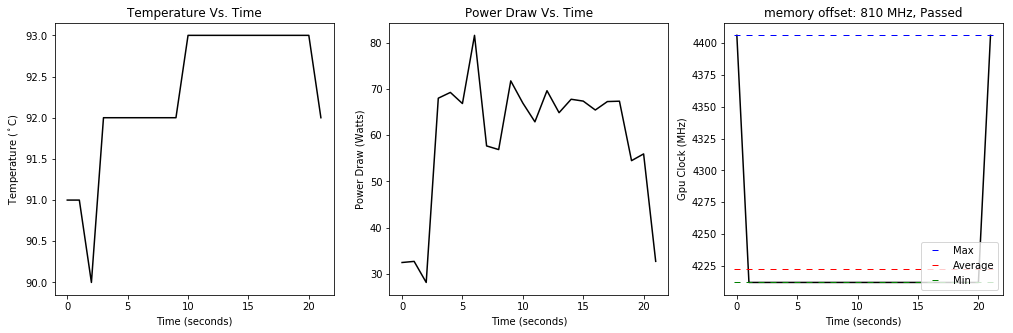

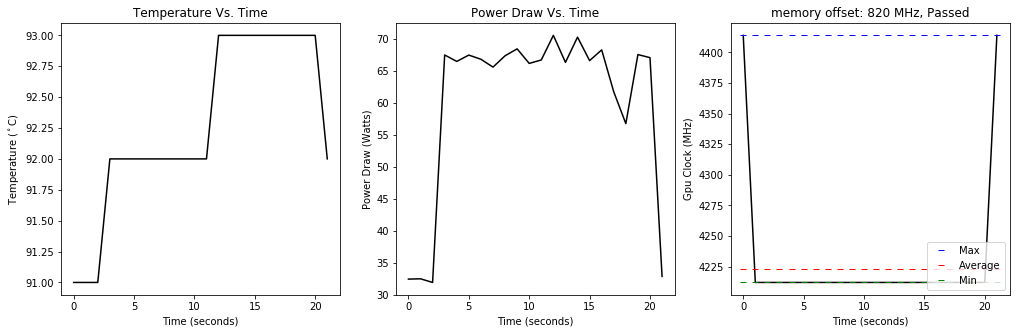

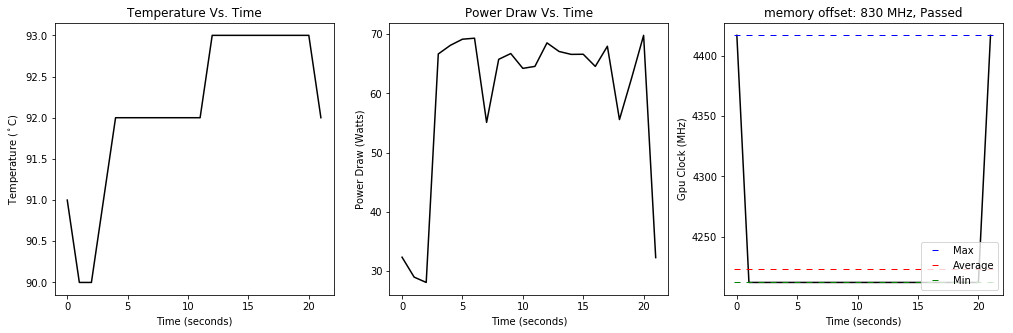

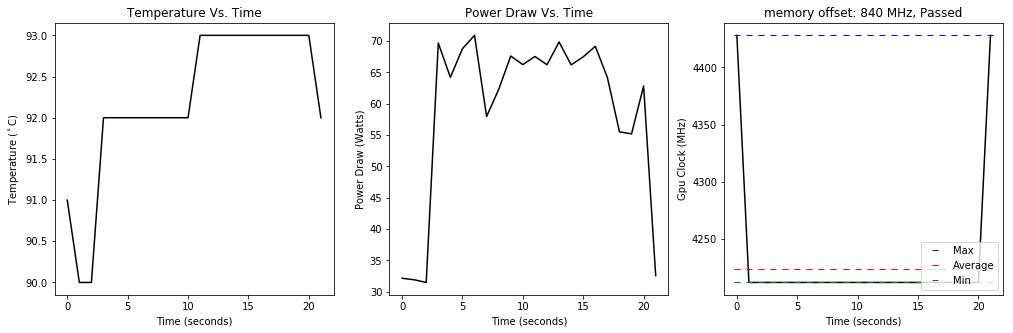

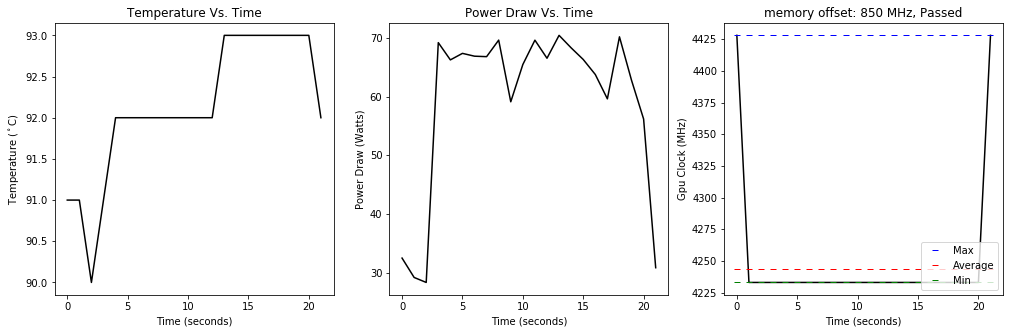

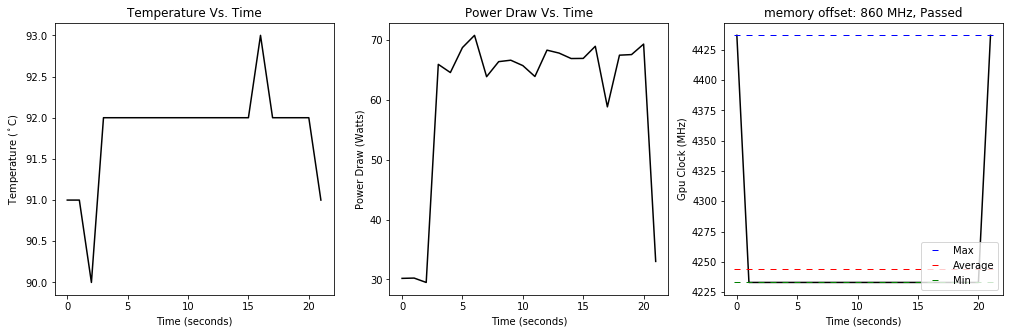

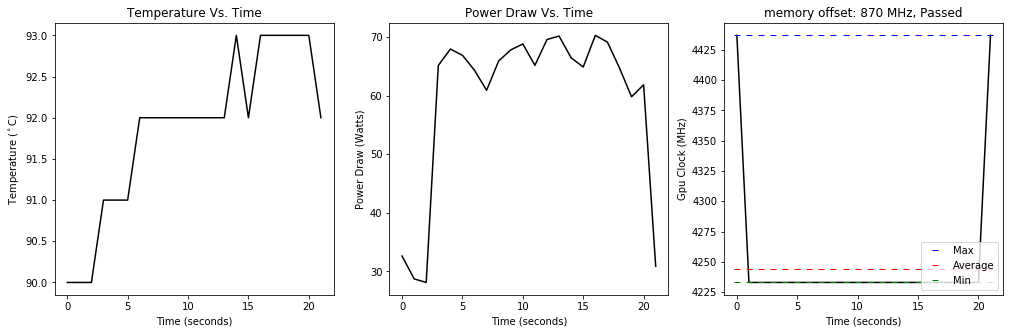

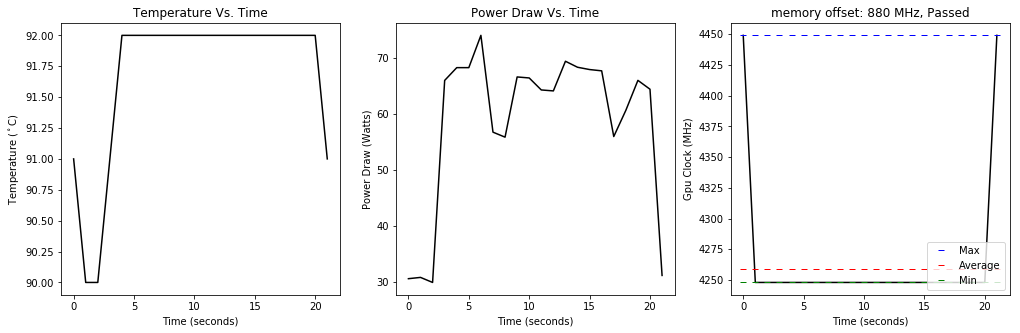

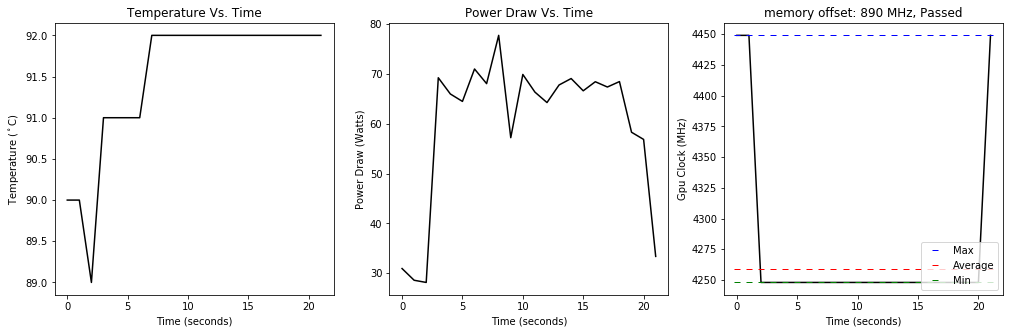

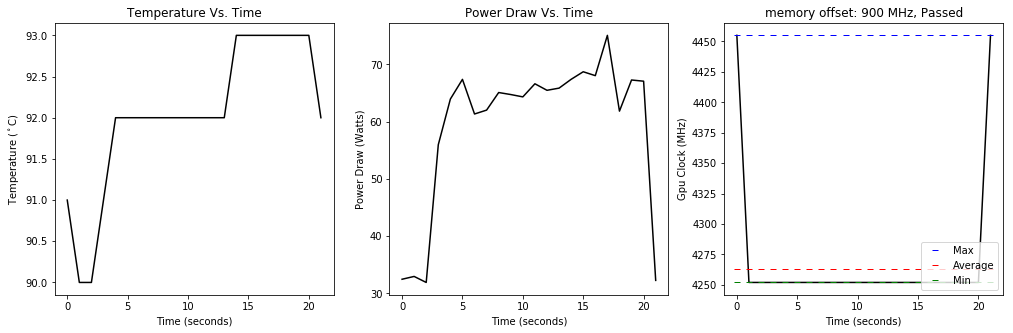

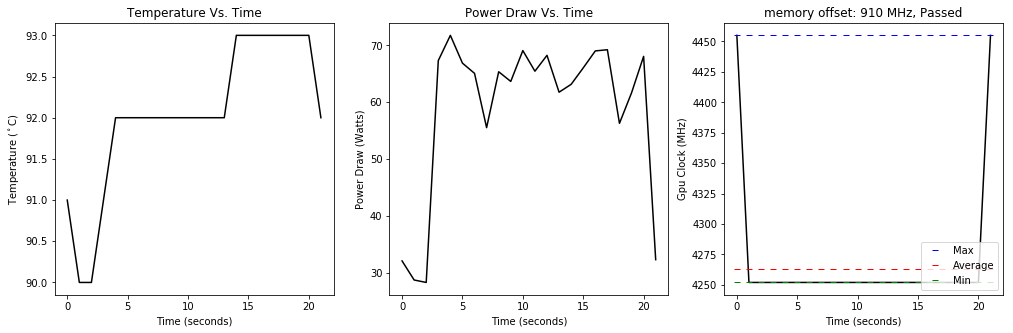

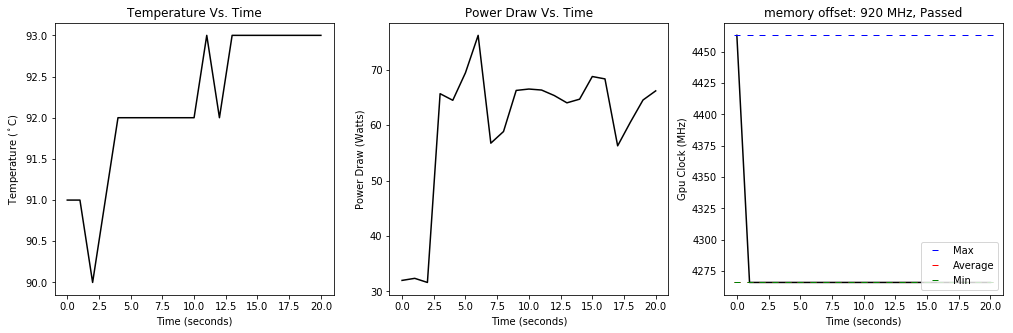

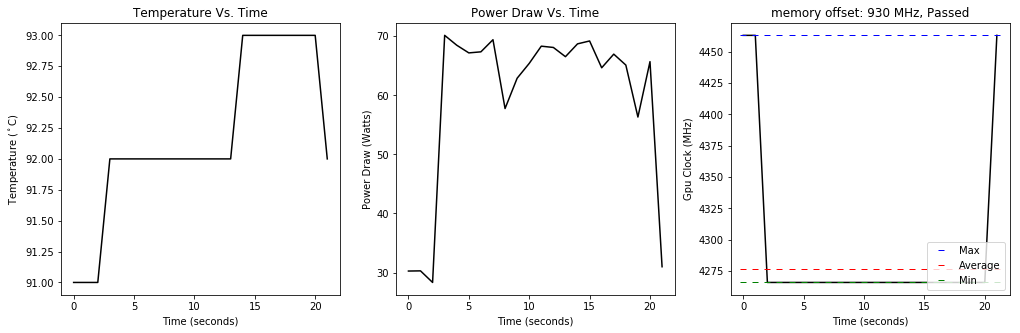

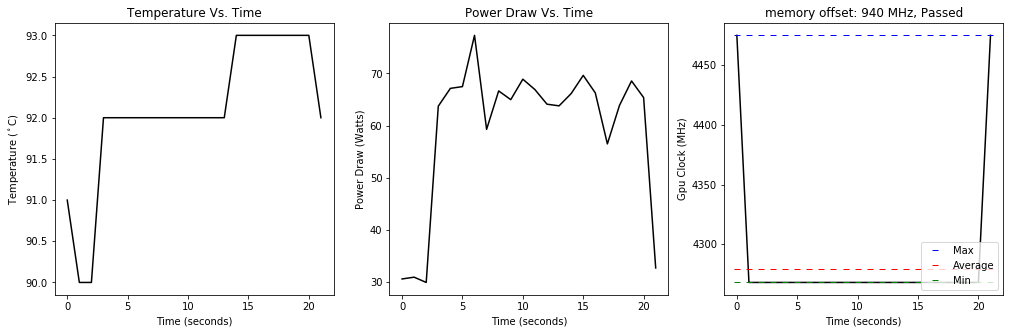

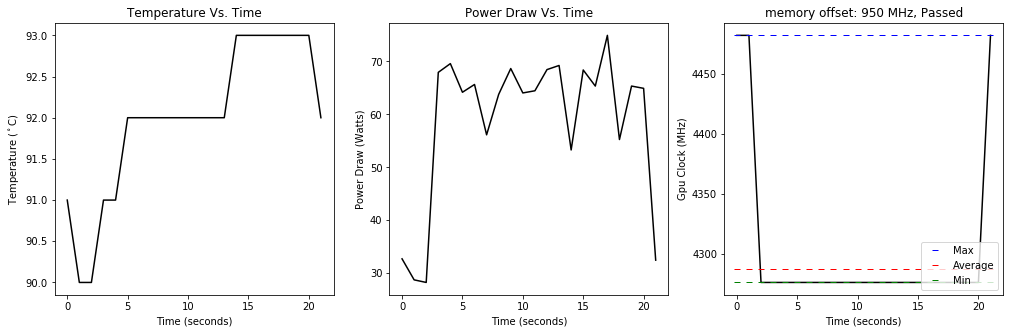

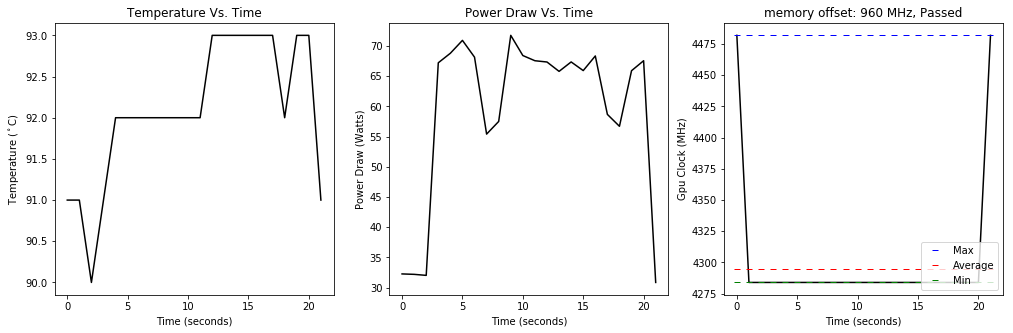

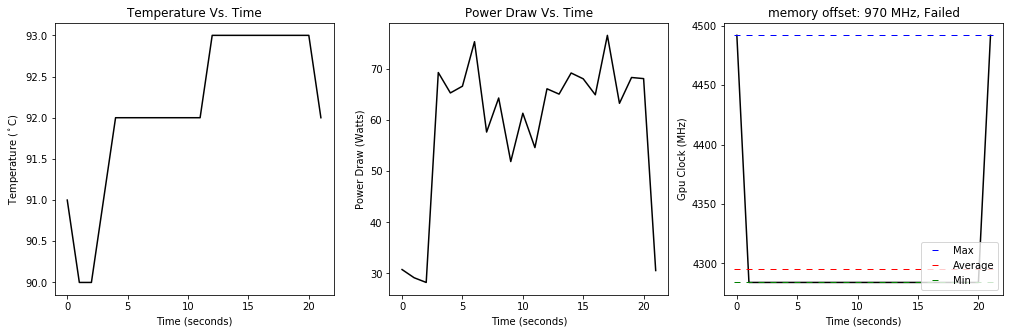

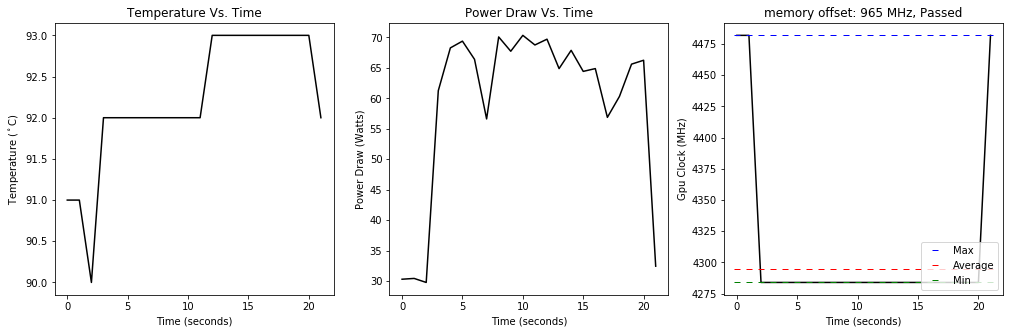

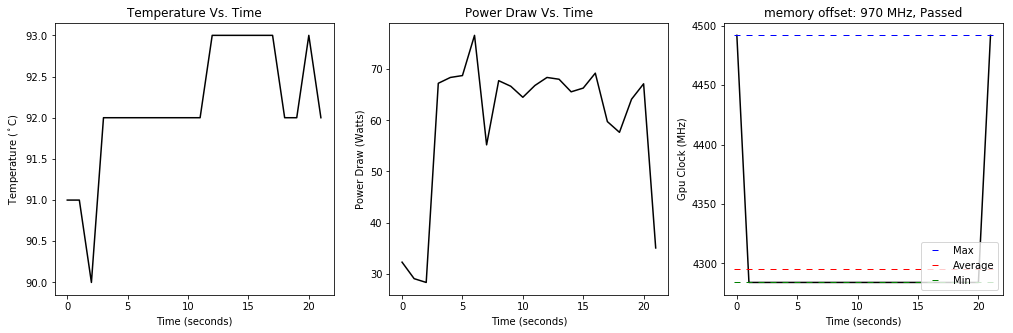

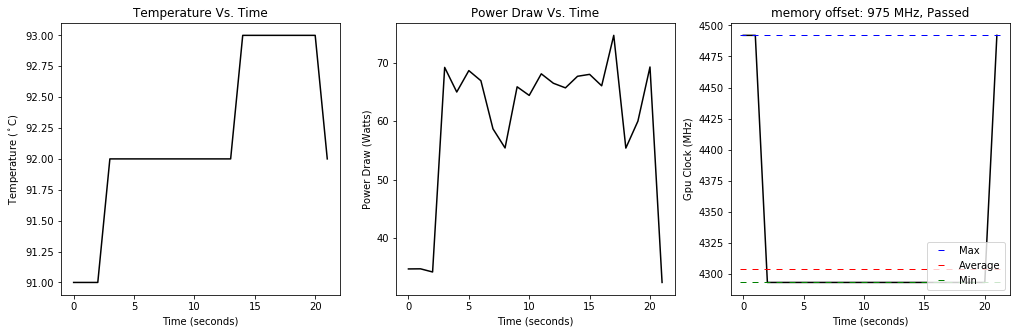

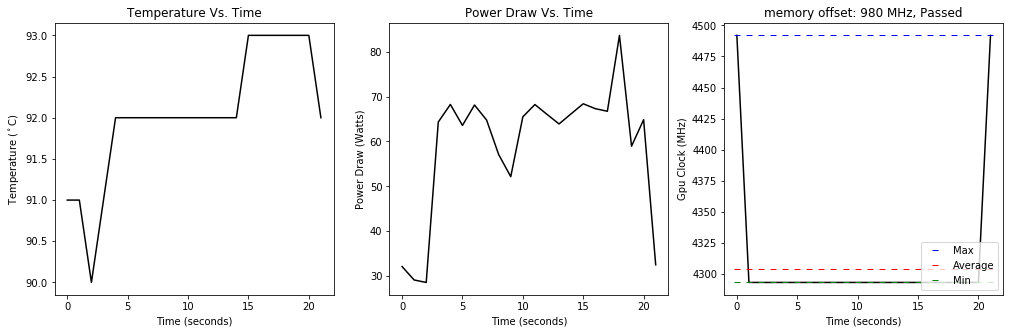

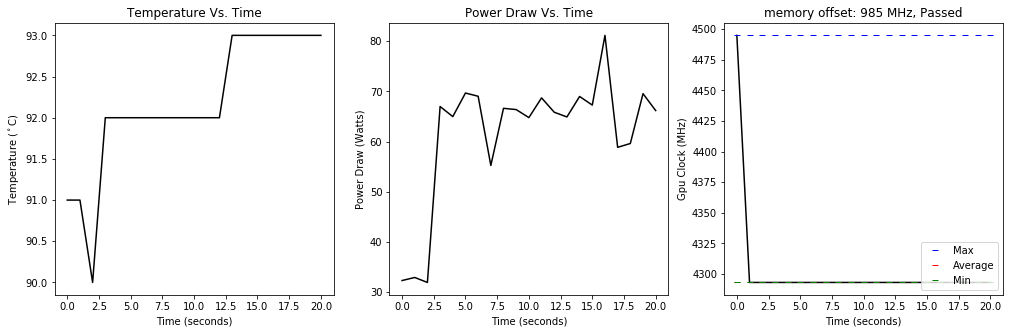

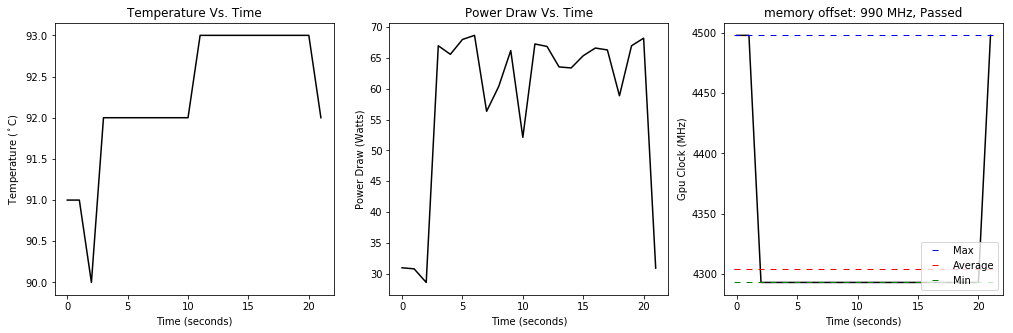

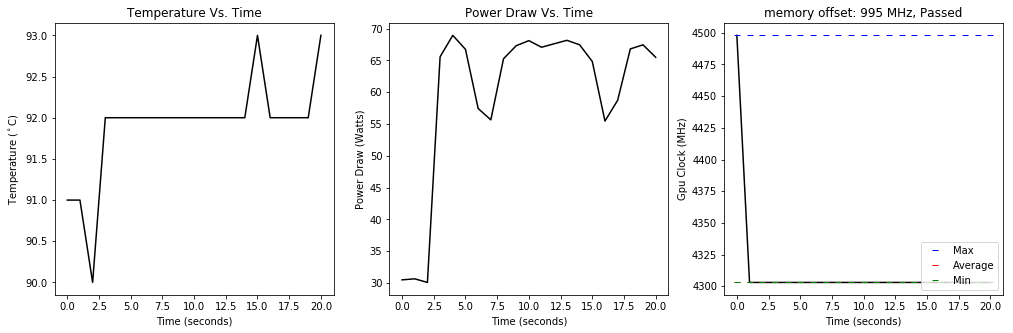

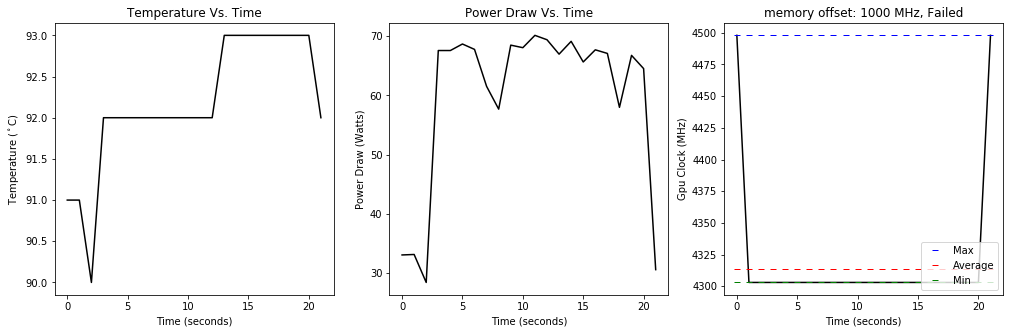

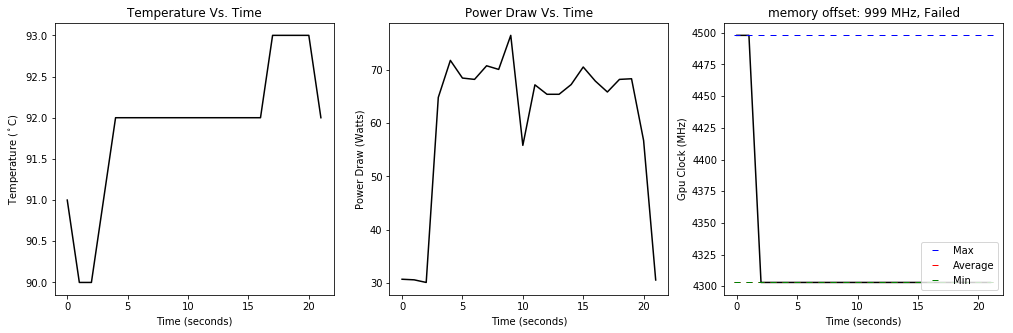

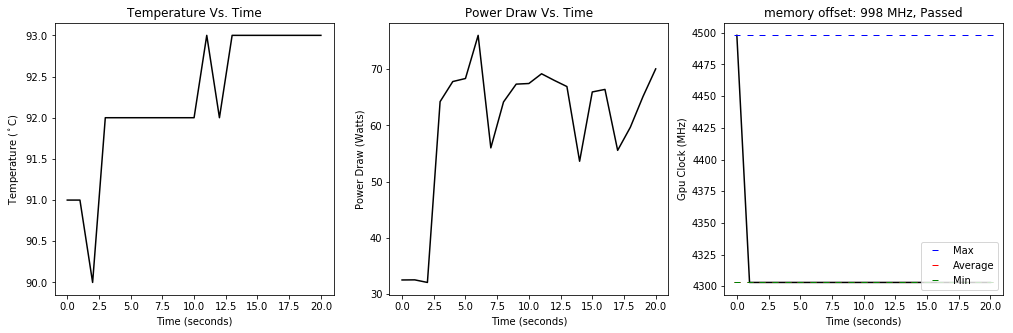

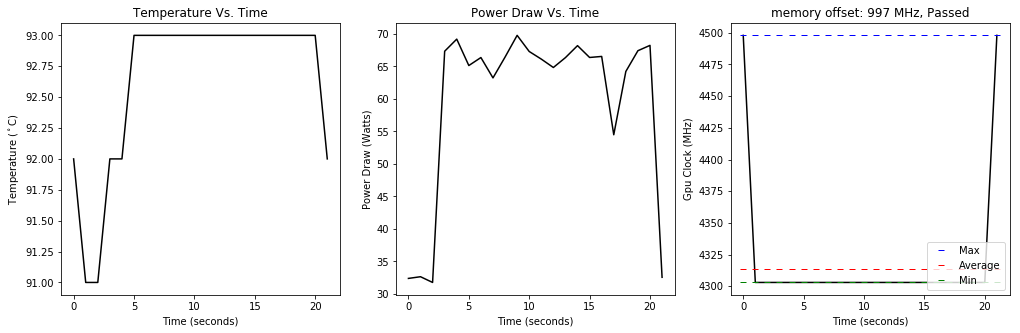

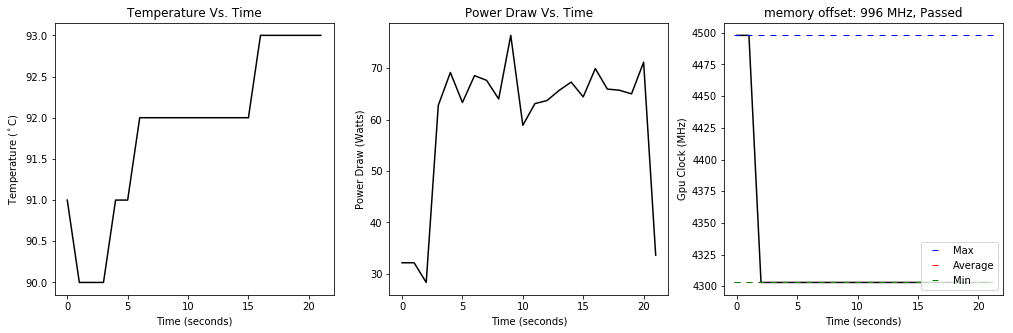

In [13]:
previous_memory_offset = -1
nrows = 1
ncols = 3
sample_rate = 1/1
for i in range(len(profiles)):
    instruction = InstructionDecoder(oc_codes[i])
    if instruction.getMemoryOffset() == 0:
        continue
    
    title_ = ''
    
    # filter failed OC profiles
    if  instruction.getOcStatus()==0 or \
        instruction.getAliveStatus()==0 or \
        instruction.getTemperatureStatus()==0 or \
        instruction.getComputeStatus==0:
        title_ = "memory offset: %s MHz, Failed"%(str(instruction.getMemoryOffset()))
    else:
        title_ = "memory offset: %s MHz, Passed"%(str(instruction.getMemoryOffset()))
        
    if instruction.getMemoryOffset() == previous_memory_offset:
        continue
    else:
        previous_memory_offset = instruction.getMemoryOffset()
    
    temperature = profiles[i][:,0]
    power_draw = profiles[i][:,1]
    gpu_core_clock = profiles[i][:,2]
    sm_clock = profiles[i][:,3]
    memory_clock = profiles[i][:,4]
    time_axis = [sample_rate*i for i in range(len(memory_clock))]
    

    plt.figure(figsize=(17, 5))
    
    plt.subplot(nrows, ncols, 1)
    plt.title("Temperature Vs. Time")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Temperature ($^\circ$C)')
    plt.plot(time_axis, temperature, '-k')
    
    plt.subplot(nrows, ncols, 2)
    plt.title("Power Draw Vs. Time")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Power Draw (Watts)')
    plt.plot(time_axis, power_draw, '-k')
    
    plt.subplot(nrows, ncols, 3)
    plt.title(title_)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Gpu Clock (MHz)')
    plt.plot(time_axis, memory_clock, '-k')
    plt.plot([np.max(memory_clock)]*int(np.ceil(time_axis[-1])+1), '_b', label='Max')
    plt.plot([np.mean(memory_clock[4:])]*int(np.ceil(time_axis[-1])+1), '_r', label='Average')
    plt.plot([np.min(memory_clock)]*int(np.ceil(time_axis[-1])+1), '_g', label='Min')
    plt.legend(loc='lower right')
    
    
    plt.show()